In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame([], columns=['a', 'b'])

In [3]:
df

,a,b


In [4]:
df.loc[0] = [1, 2]
df.loc[1] = [3, 4]

In [8]:
for x in df.itertuples():
    print(type(x))
    print(x)

<class 'pandas.core.frame.Pandas'>
Pandas(Index=0, a=1, b=2)
<class 'pandas.core.frame.Pandas'>
Pandas(Index=1, a=3, b=4)


In [2]:
import numpy as np

x = ["a", "a", "b", "a", "c"]
print(np.unique(x, return_inverse=True))

(array(['a', 'b', 'c'], dtype='<U1'), array([0, 0, 1, 0, 2], dtype=int64))


In [10]:
import pickle
import numpy as np
from hyperopt import Trials
import matplotlib.pyplot as plt

with open("bayes_trials.bin", "rb") as f:
    trials = pickle.load(f)

In [11]:
losses = - np.array(trials.losses())

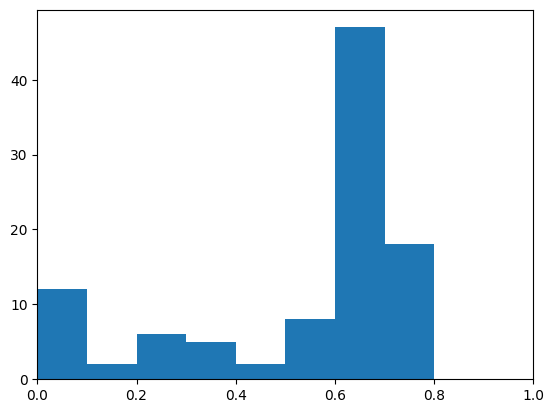

In [15]:
plt.xlim(0, 1)
plt.hist(losses // 0.1 * 0.1, bins=[0.1 * i for i in range(11)])
plt.savefig("hist_100.png")

In [5]:
losses // 0.1 * 0.1

array([0. , 0.5, 0. , 0. , 0.5, 0.7, 0.6, 0. , 0.6, 0.5, 0.2, 0.6, 0.5,
       0. , 0.6, 0. , 0.6, 0.6, 0.6, 0. , 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.7, 0.3, 0.7, 0.7, 0.5, 0.7, 0.1, 0.6, 0.6, 0.6, 0.6, 0.6, 0. ,
       0.6, 0.5, 0.2, 0.6, 0. , 0.3, 0.1, 0.6, 0.5, 0.6, 0.3, 0.2, 0.6,
       0.6, 0.6, 0.6, 0.2, 0.3, 0.6, 0.7, 0.6, 0.7, 0.7, 0.2, 0.5, 0.6,
       0.7, 0.6, 0.7, 0.6, 0.7, 0.6, 0.6, 0.6, 0.6, 0. , 0.7, 0.7, 0.7,
       0.6, 0.6, 0.6, 0.4, 0.6, 0.7, 0.6, 0.7, 0.6, 0.4, 0.6, 0.7, 0. ,
       0.2, 0. , 0.7, 0.6, 0.6, 0.6, 0.3, 0.6, 0.6])

In [12]:
losses

array([0.08003316, 0.57771765, 0.07993817, 0.07984544, 0.57361267,
       0.70517991, 0.61891266, 0.07981361, 0.68248312, 0.5862991 ,
       0.24652262, 0.66698674, 0.53539127, 0.07985919, 0.66473225,
       0.08011386, 0.63859074, 0.65104792, 0.6663253 , 0.08037947,
       0.66770241, 0.64247801, 0.62474053, 0.61129302, 0.64153145,
       0.64617524, 0.70632618, 0.34473319, 0.7019712 , 0.70499184,
       0.56921032, 0.70267786, 0.18440664, 0.64618429, 0.69794678,
       0.66734427, 0.63992459, 0.645705  , 0.07993016, 0.60757906,
       0.59139183, 0.26483381, 0.62396951, 0.07992545, 0.30001566,
       0.18824385, 0.66018956, 0.59086785, 0.66859593, 0.38519775,
       0.21263746, 0.69507481, 0.66921326, 0.60840178, 0.62447251,
       0.21271563, 0.37775064, 0.67713003, 0.70755053, 0.66396862,
       0.70711266, 0.70509368, 0.22853642, 0.59990153, 0.6027036 ,
       0.70437485, 0.69692603, 0.70696085, 0.64619379, 0.70037961,
       0.64078201, 0.69229244, 0.68790446, 0.60428574, 0.08517